# 📈 Time Series Forecasting of Wikipedia Pageviews for Figma (software)

This notebook explores daily pageviews for the [Figma Wikipedia article](https://en.wikipedia.org/wiki/Figma_(software)) from January 2022 onwards.  
The objective is to build a time series model that forecasts daily pageviews until mid-2026.  
This task was developed as part of a Data Science Internship technical challenge at SearchPilot.


## 📚 Table of Contents
1. [Introduction](#Introduction)
2. [Importing Libraries](#Importing-libraries)
3. [Data Loading](#data-loading)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Time Series Decomposition](#time-series-decomposition)
6. [Forecasting with Prophet](#forecasting-with-prophet)
7. [Forecast Visualization](#forecast-visualization)
8. [Conclusion](#conclusion)


# Introduction
This notebook aims to forecast the **daily number of pageviews** for the Wikipedia page "*Figma (software)*" from now (June 2025) until **mid-2026**.

To do so, we apply **time series forecasting techniques** based on historical data collected from Wikipedia's public API. We include multiple years of data to capture **seasonal trends**, **long-term patterns**, and **periodic fluctuations** in user interest.


## 📚 Background: Time Series Forecasting

Time series forecasting is a method for predicting future data points based on previously observed values. It is commonly used in domains such as finance, energy, climate science, and web analytics.

A time series may exhibit:
- **Trend**: A long-term upward or downward movement.
- **Seasonality**: Repeating patterns across fixed periods (e.g., weekly, yearly).
- **Cyclicality**: Long-term fluctuations influenced by external factors.
- **Noise**: Random variation or outliers in the data.

We use this structure to model daily Wikipedia traffic and produce a robust forecast.


To achieve accurate and meaningful forecasts, we need to consider several important factors:

---

### Key Considerations

#### Daily Granularity
- Wikipedia pageviews are recorded **daily**, so we must capture:
  - **Weekly seasonality** (e.g., weekday vs. weekend traffic)
  - **Monthly or yearly cycles** (e.g., usage spikes after product updates or events)

#### 📊 Sufficient Training Data
To detect and model recurring patterns, the dataset must include **at least 2–3 years of historical daily data**, allowing the model to learn:
- **Annual cycles** (e.g., high-traffic periods tied to product launches or academic seasons)
- **Weekly behavior** (e.g., lower weekend traffic)
- **Long-term trends** in popularity or awareness

#### Data Availability
Wikipedia offers public access to pageview statistics via:
- The **Wikimedia API**
- The **Pageviews Analysis Tool**

By retrieving pageview data from **January 2022 to June 2025**, we can collect approximately **1,250 daily observations**, which is sufficient for training robust forecasting models such as:
- **SARIMA** – for capturing seasonality and trends
- **Prophet** – for flexible component-based modeling including holidays and anomalies
- **LSTM** – if deep learning and sequence modeling is explored

#### Forecast Horizon
Forecasting more than one year into the future (mid-2026) qualifies as a **long-horizon forecasting problem**. To reduce error drift and improve prediction quality:
- The model must observe long-term **patterns**, **anomalies**, and **trends** in the historical dataset.

---

### Summary

From both an academic and applied perspective in time series forecasting:

- It's best to use at least **2.5 to 3.5 years** of daily historical data.
- We collect data from **January 2022 to June 2025**.
- We use forecasting methods suitable for time series behavior and web traffic patterns.

---

## Importing-libraries

In [10]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 2.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.0/991.0 kB 2.7 MB/s eta 0:00:00a 0:00:01m


In [7]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series forecasting
from prophet import Prophet

# Date handling
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [69]:
import requests
from datetime import datetime

def fetch_wikipedia_pageviews(article, start_date, end_date, project='en.wikipedia', access='all-access', agent='user'):
    """
    Fetches daily pageviews for a Wikipedia article using the Wikimedia REST API.
    """
    url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/daily/{start_date}/{end_date}'
    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'  
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")
    
    data = response.json()
    records = []
    for item in data['items']:
        date = datetime.strptime(str(item['timestamp']), '%Y%m%d%H')
        views = item['views']
        records.append({'date': date, 'views': views})
    
    df = pd.DataFrame(records)
    return df

# Parameters
article_title = 'Figma_(software)'
start = '20220101'
end = datetime.today().strftime('%Y%m%d')

# Fetch data
df = fetch_wikipedia_pageviews(article_title, start, end)


In [71]:
df.head()

,date,views
0,2022-01-01,632
1,2022-01-02,742
2,2022-01-03,1134
3,2022-01-04,1217
4,2022-01-05,1378


In [22]:
df.describe()

,date,views
count,1250,1250.000000
mean,2023-09-17 12:00:00,948.308000
min,2022-01-01 00:00:00,13.000000
25%,2022-11-09 06:00:00,51.250000
50%,2023-09-17 12:00:00,985.000000
75%,2024-07-25 18:00:00,1563.750000
max,2025-06-03 00:00:00,36996.000000
std,NaN,1697.810192


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [26]:
df.to_csv("figma_wikipedia_pageviews_2022_onward.csv", index=False)

In [ ]:
import os
print(os.getcwd())

### Fetch Data on Daily, Monthly, and Agent basis:

In [20]:
import requests
from datetime import datetime

In [73]:
def fetch_pageviews(article='Figma_(software)', start_date='2022-01-01', end_date=None,
                    granularity='daily', platform='all-access', agent='user', project='en.wikipedia'):
    """
    Fetches pageviews for a Wikipedia article using the Wikimedia REST API.
    """

    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    # Convert dates to API format
    start_fmt = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_fmt = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')

    # Build API URL
    url = (
        f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/'
        f'{project}/{platform}/{agent}/{article}/{granularity}/{start_fmt}/{end_fmt}'
    )

    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")

    data = response.json()

    records = []
    for item in data['items']:
        full_date = datetime.strptime(str(item['timestamp']), '%Y%m%d%H')
        date = full_date if granularity == 'daily' else datetime(full_date.year, full_date.month, 1)
        views = item['views']
        records.append({'date': date, 'views': views})

    return pd.DataFrame(records)


In [75]:
# Daily, all-access, user traffic
df_daily = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')

# Monthly, desktop traffic
df_monthly = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03', granularity='monthly', platform='desktop')

# Daily, mobile-web + spider traffic
df_spider_mobile = fetch_pageviews(start_date='2023-01-01', end_date='2024-01-01', platform='mobile-web', agent='spider')


In [77]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [28]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    42 non-null     datetime64[ns]
 1   views   42 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 804.0 bytes


In [30]:
df_spider_mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   views   366 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


## Exploratory-Data-Analysis

Exploratory Data Analysis (EDA) is a critical first step in any time series forecasting project. It helps uncover the underlying patterns in the data, including trends, seasonality, anomalies, and missing values. This understanding is essential to select appropriate forecasting methods and preprocessing techniques.

For this project, EDA will include:

- **Trend analysis**: Observing long-term increases or decreases in pageviews.
- **Seasonality detection**: Identifying repeating patterns such as weekly cycles (e.g., higher traffic on weekdays).
- **Anomaly detection**: Finding outliers in traffic that may result from product announcements or media coverage.
- **Missing values**: Checking for any gaps in the time series.
- **Autocorrelation analysis**: Understanding how past values influence future values.
- **Time series decomposition**: Breaking the series into trend, seasonality, and residual components to better understand its structure.

By applying these techniques, we gain insights into the dynamics of Wikipedia traffic for the "Figma (software)" page, which will inform our modeling decisions and improve forecast accuracy.


In [79]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [63]:
# Convert date column to datetime and set index
# df_daily['date'] = pd.to_datetime(df_daily['date'])
# df_daily.set_index('date', inplace=True)

🔎 Data Summary:
              views
count   1250.000000
mean     948.308000
std     1697.810192
min       13.000000
25%       51.250000
50%      985.000000
75%     1563.750000
max    36996.000000

Missing values: views    0
dtype: int64


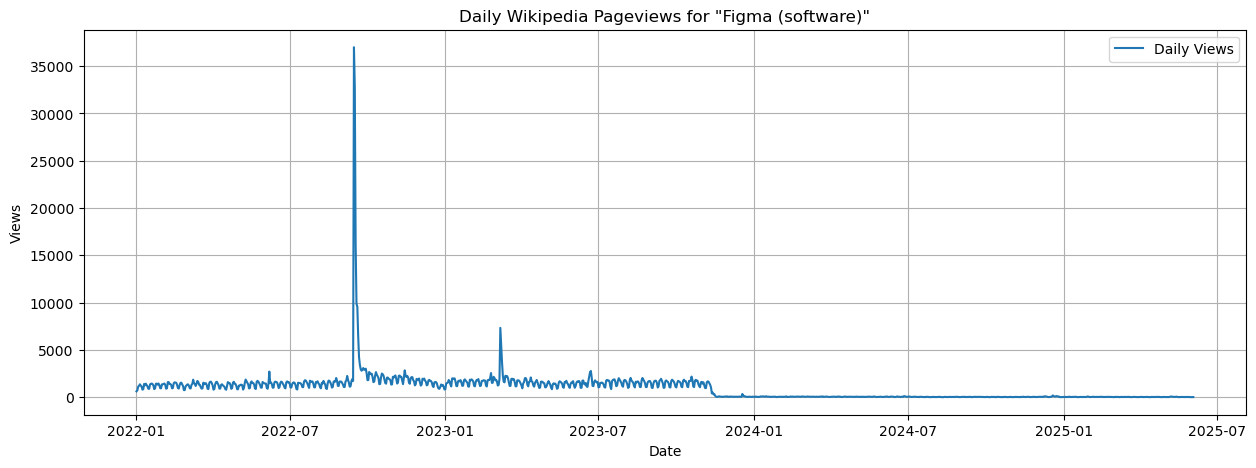

In [37]:
# 1. Basic Summary
print("🔎 Data Summary:")
print(df_daily.describe())
print("\nMissing values:", df_daily.isnull().sum())

# 2. Line Plot to Visualize Trends
plt.figure(figsize=(15, 5))
plt.plot(df_daily.index, df_daily['views'], label='Daily Views')
plt.title('Daily Wikipedia Pageviews for "Figma (software)"')
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

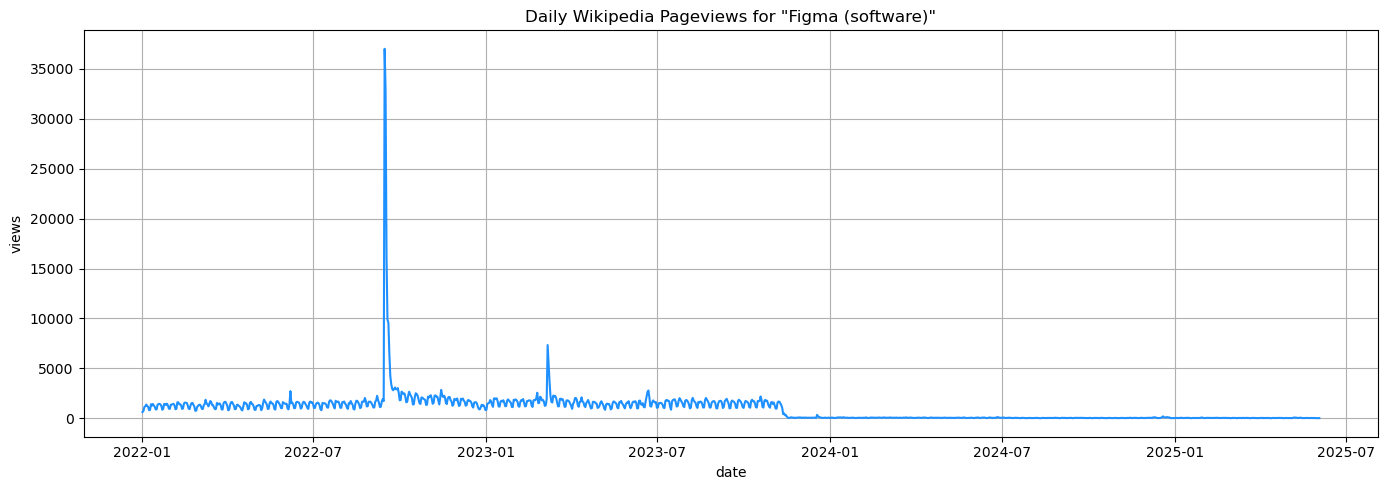

In [81]:


# Load the daily data
df = df_daily.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 1. Line Plot: Overall Trend
plt.figure(figsize=(14, 5))
plt.plot(df['views'], color='dodgerblue')
plt.title('Daily Wikipedia Pageviews for "Figma (software)"')
plt.ylabel('views')
plt.xlabel('date')
plt.grid(True)
plt.tight_layout()
plt.show()


### Outlier Detection Using the IQR Method

Outliers can significantly affect time series models, especially in forecasting tasks. For this analysis, we use the Interquartile Range (IQR) method to detect anomalous values.

**Steps:**
1. Compute Q1 (25th percentile) and Q3 (75th percentile) of the `views` data.
2. Calculate the IQR = Q3 - Q1.
3. Define outlier bounds:
   - Lower bound = Q1 - 1.5 * IQR
   - Upper bound = Q3 + 1.5 * IQR
4. Mark any data points outside these bounds as outliers.

This method helps to isolate unusually high or low pageview counts, which may correspond to:
- Special events
- Product announcements
- Bot or automated traffic

These outliers are **not removed**, but are flagged and handled carefully in modeling steps to evaluate their influence on forecast performance.


In [85]:

# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_daily['views'].quantile(0.25)
Q3 = df_daily['views'].quantile(0.75)

# Step 2: Compute IQR
IQR = Q3 - Q1

# Step 3: Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Identify outliers
df_daily['is_outlier'] = (df_daily['views'] < lower_bound) | (df_daily['views'] > upper_bound)

# Step 5: Preview the outliers
outliers = df_daily[df_daily['is_outlier']]
print(outliers[['date', 'views']])


          date  views
257 2022-09-15  36996
258 2022-09-16  32835
259 2022-09-17  16178
260 2022-09-18   9883
261 2022-09-19   9572
262 2022-09-20   6485
263 2022-09-21   4244
430 2023-03-07   7341
431 2023-03-08   5424


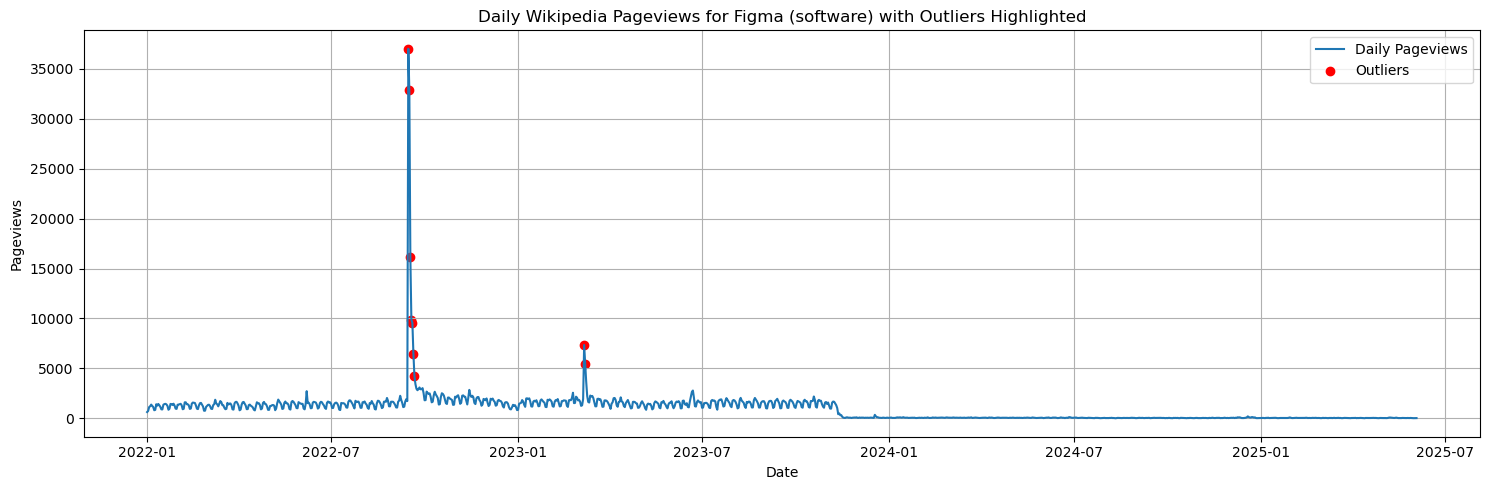

In [87]:
# Outlier Visualization
plt.figure(figsize=(15, 5))
plt.plot(df_daily['date'], df_daily['views'], label='Daily Pageviews')
plt.scatter(outliers['date'], outliers['views'], color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Pageviews')
plt.title('Daily Wikipedia Pageviews for Figma (software) with Outliers Highlighted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [83]:
# Identify outliers
outliers_df = df[df['is_outlier'] == True]

# Show the outlier dates and values
print(outliers_df[['views']])

KeyError: 'is_outlier'

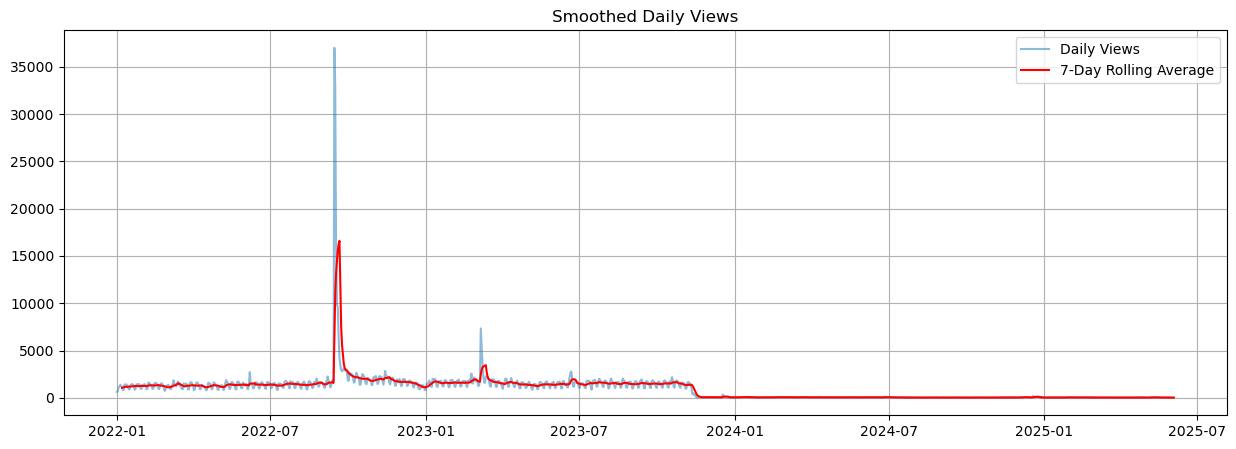

In [49]:
# 3. Rolling Average (7-day smoothing)
df_daily['rolling_mean'] = df_daily['views'].rolling(window=7).mean()
plt.figure(figsize=(15, 5))
plt.plot(df_daily['views'], alpha=0.5, label='Daily Views')
plt.plot(df_daily['rolling_mean'], color='red', label='7-Day Rolling Average')
plt.title('Smoothed Daily Views')
plt.legend()
plt.grid()
plt.show()

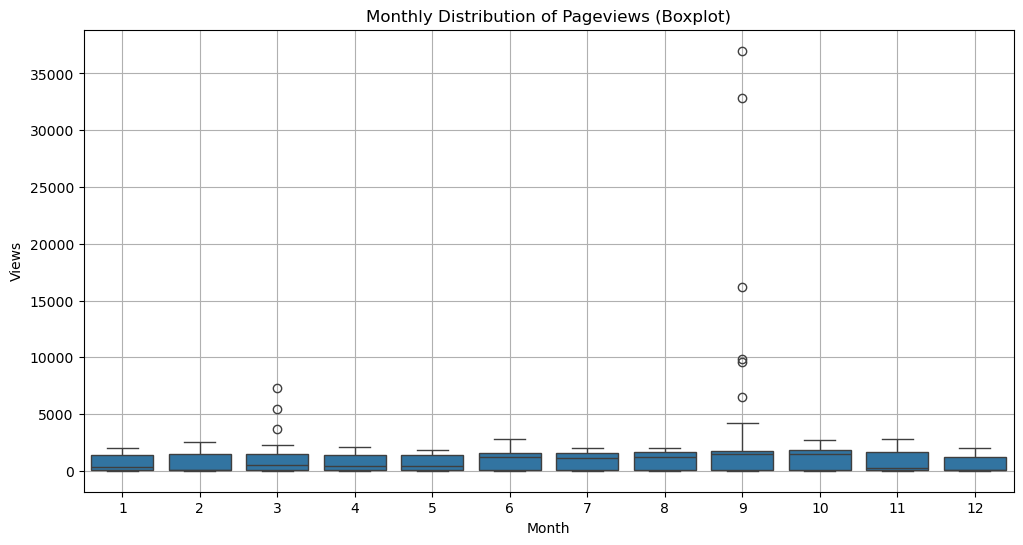

In [51]:
# 4. Boxplot to Detect Outliers by Month
df_daily['month'] = df_daily.index.month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='views', data=df_daily)
plt.title("Monthly Distribution of Pageviews (Boxplot)")
plt.xlabel("Month")
plt.ylabel("Views")
plt.grid()
plt.show()

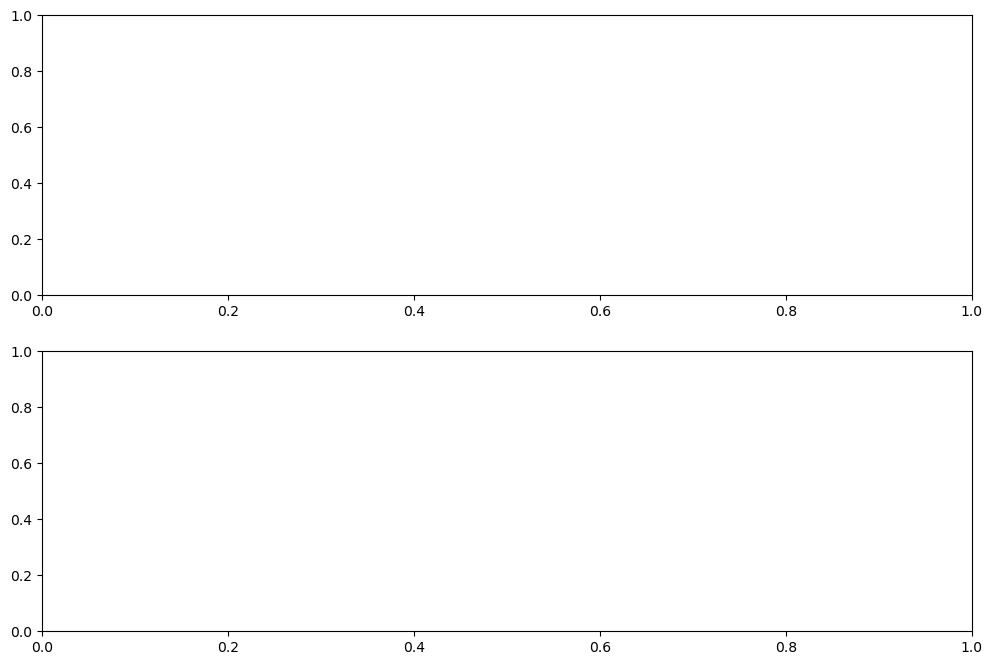

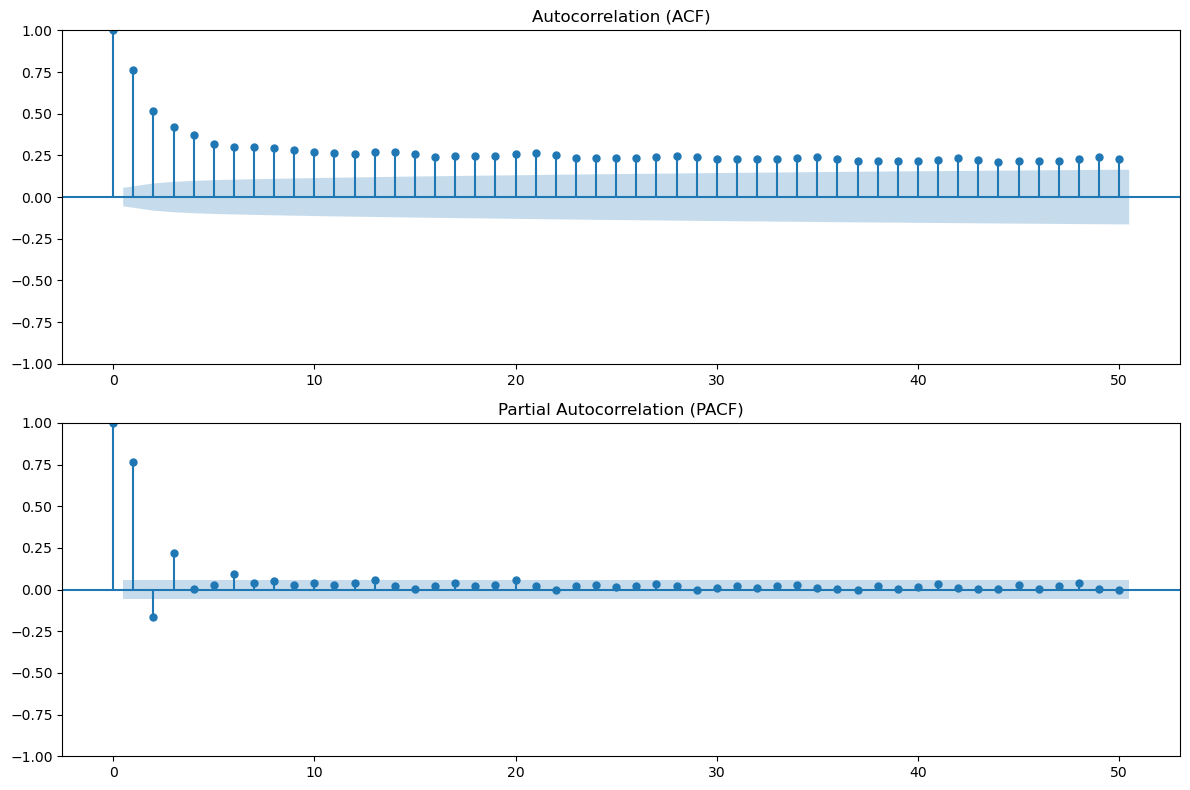

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 5. Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_daily['views'], lags=50, ax=ax[0])
plot_pacf(df_daily['views'], lags=50, ax=ax[1])
ax[0].set_title("Autocorrelation (ACF)")
ax[1].set_title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

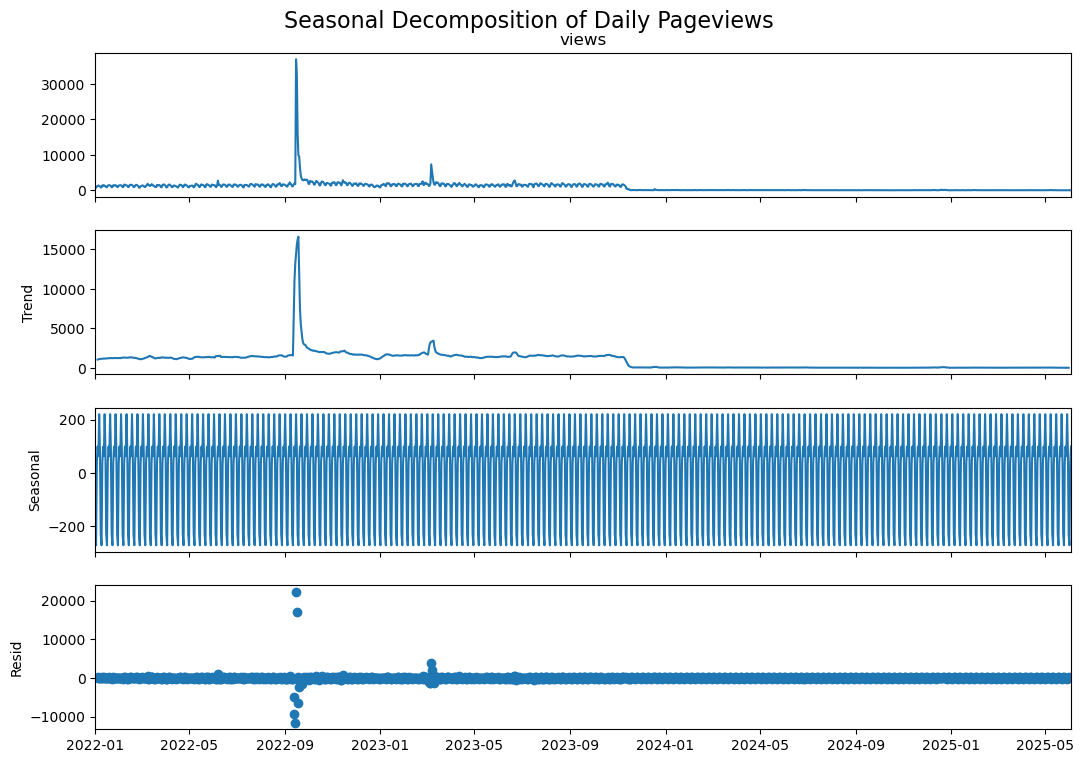

In [59]:
import statsmodels.api as sm
# 6. Time Series Decomposition
decomposition = sm.tsa.seasonal_decompose(df_daily['views'], model='additive', period=7)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Daily Pageviews", fontsize=16)
plt.show()
